## Milestone 5

Final project code 

In [ ]:
!wget -q https://github.com/idmmachinelearning-ms/Project/blob/main/projectutils.py

In [1]:
!wget -q https://github.com/DM-GY-9103-2024F-H/9103-utils/raw/main/src/data_utils.py

!wget -qO- https://github.com/DM-GY-9103-2024F-H/9103-utils/releases/latest/download/att-faces.tar.gz | tar xz

### Loading in Tools

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import OrdinalEncoder

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

!pip install datasets transformers huggingface_hub

!apt-get install git-lfs

import datasets
from datasets import load_dataset, Dataset, DatasetDict

from transformers import AutoTokenizer, pipeline

from collections import Counter

from IPython.display import Audio
from sklearn.model_selection import train_test_split

from data_utils import PCA, RandomForestClassifier, StandardScaler
from data_utils import KMeansClustering, SpectralClustering
from data_utils import object_from_json_url, classification_error, display_confusion_matrix





[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Creating the Poetry Dataframe

In [3]:
# one cell to create df that I can bring into final project

updatedpoems = open("./poetrydatasetml.txt", encoding='utf8').read()
all_lines = updatedpoems.split("\n\n\n")

titles = []
lines = []
words = []
length = []

for t in all_lines:
    a = t.split("\n\n")
    titles.append(a[0])
    lines.append(a[1:])

titles[0] = "Introduction"

for w in lines:
    a = " ".join(w)
    b = a.replace("\n", " ")
    c = b.split(" ")
    words.append(c)

for w in words:
    length.append(len(w))
    

poems_df = pd.DataFrame(titles)
poems_df["Lines"] = lines
poems_df["Words"] = words
poems_df["Length"] = length
poems_df["Text"] = poems_df["Lines"].apply(lambda ls: "\n".join(ls))

poems_df.columns = ["Title", "Lines", "Words", " Word Length", "Text"]


In [4]:
poems_df.head()

,Title,Lines,Words,Word Length,Text
0,Introduction,"[Introduction, Cycles can be stupid. You know ...","[Introduction, Cycles, can, be, stupid., You, ...",550,Introduction\nCycles can be stupid. You know w...
1,Whenever it’s convenient!,[Screaming\nI want you to see me\nPlease could...,"[Screaming, I, want, you, to, see, me, Please,...",27,Screaming\nI want you to see me\nPlease could ...
2,Larger than Life,"[Biding my time,\nI am in no rush.\nPaintbrush...","[Biding, my, time,, I, am, in, no, rush., Pain...",180,"Biding my time,\nI am in no rush.\nPaintbrush ..."
3,Google Keep,[poems that sit in notes on my phone\nlittered...,"[poems, that, sit, in, notes, on, my, phone, l...",72,poems that sit in notes on my phone\nlittered ...
4,Google Keep 2,[poems that sit in notes on my phone\nscribble...,"[poems, that, sit, in, notes, on, my, phone, s...",92,poems that sit in notes on my phone\nscribbles...


### Adding Hugging Face Sentiment Analysis to the Dataframe

In [4]:
huggingfacepoem = Dataset.from_pandas(poems_df)
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def preprocess_function(examples):
   return tokenizer(examples["Text"], truncation=True)


In [5]:
sentiment_all_poems = huggingfacepoem.map(preprocess_function, batched=True)

Map: 100%|██████████| 164/164 [00:00<00:00, 2602.06 examples/s]


In [6]:
classifier = pipeline("text-classification",model='bhadresh-savani/distilbert-base-uncased-emotion', return_all_scores=True)
prediction = classifier(sentiment_all_poems["Text"], padding=True, truncation=True)
print(prediction)

Device set to use cpu
/usr/local/python/3.12.1/lib/python3.12/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


[[{'label': 'sadness', 'score': 0.004606499802321196}, {'label': 'joy', 'score': 0.046192727982997894}, {'label': 'love', 'score': 0.0016051274724304676}, {'label': 'anger', 'score': 0.034378472715616226}, {'label': 'fear', 'score': 0.9120852947235107}, {'label': 'surprise', 'score': 0.001131819561123848}], [{'label': 'sadness', 'score': 0.023822134360671043}, {'label': 'joy', 'score': 0.004872847814112902}, {'label': 'love', 'score': 0.011757900007069111}, {'label': 'anger', 'score': 0.8253984451293945}, {'label': 'fear', 'score': 0.13271522521972656}, {'label': 'surprise', 'score': 0.0014334057923406363}], [{'label': 'sadness', 'score': 0.010388486087322235}, {'label': 'joy', 'score': 0.9530593156814575}, {'label': 'love', 'score': 0.002446320140734315}, {'label': 'anger', 'score': 0.029157329350709915}, {'label': 'fear', 'score': 0.004027944058179855}, {'label': 'surprise', 'score': 0.0009206123650074005}], [{'label': 'sadness', 'score': 0.3815634250640869}, {'label': 'joy', 'score'

To test out, here is a poem and its corresponding sentiment analysis: 

- Marco?

- A trail of breadcrumbs
- A child anxiously waiting
- Who will play their game?


- {'label': 'sadness', 'score': 0.0014290023827925324},
- {'label': 'joy', 'score': 0.004451319109648466},
- {'label': 'love', 'score': 0.0005325597594492137},
- {'label': 'anger', 'score': 0.03763354569673538},
- {'label': 'fear', 'score': 0.9546623826026917},
- {'label': 'surprise', 'score': 0.0012912263628095388}]

Let's add a column of each label to the dataframe for each poem. 

In [7]:
sadness = []
joy = []
love = []
anger = []
fear = []
surprise = []

for p in range(len(prediction)):
    sadness.append(prediction[p][0]['score'])
    joy.append(prediction[p][1]['score'])
    love.append(prediction[p][2]['score'])
    anger.append(prediction[p][3]['score'])
    fear.append(prediction[p][4]['score'])
    surprise.append(prediction[p][5]['score'])


In [8]:
poems_df["Sadness"] = sadness
poems_df["Joy"] = joy
poems_df["Love"] = love
poems_df["Anger"] = anger
poems_df["Fear"] = fear
poems_df["Surprise"] = surprise

In [13]:
poems_df.head()

,Title,Lines,Words,Word Length,Text,Sadness,Joy,Love,Anger,Fear,Surprise
0,Introduction,"[Introduction, Cycles can be stupid. You know ...","[Introduction, Cycles, can, be, stupid., You, ...",550,Introduction\nCycles can be stupid. You know w...,0.004606,0.046193,0.001605,0.034378,0.912085,0.001132
1,Whenever it’s convenient!,[Screaming\nI want you to see me\nPlease could...,"[Screaming, I, want, you, to, see, me, Please,...",27,Screaming\nI want you to see me\nPlease could ...,0.023822,0.004873,0.011758,0.825398,0.132715,0.001433
2,Larger than Life,"[Biding my time,\nI am in no rush.\nPaintbrush...","[Biding, my, time,, I, am, in, no, rush., Pain...",180,"Biding my time,\nI am in no rush.\nPaintbrush ...",0.010388,0.953059,0.002446,0.029157,0.004028,0.000921
3,Google Keep,[poems that sit in notes on my phone\nlittered...,"[poems, that, sit, in, notes, on, my, phone, l...",72,poems that sit in notes on my phone\nlittered ...,0.381563,0.025545,0.002885,0.484708,0.101736,0.003562
4,Google Keep 2,[poems that sit in notes on my phone\nscribble...,"[poems, that, sit, in, notes, on, my, phone, s...",92,poems that sit in notes on my phone\nscribbles...,0.000948,0.002342,0.995206,0.000341,0.000619,0.000544


### Preparing Data to Cluster Poems by Sentiment

In [18]:
features = poems_df.drop(columns=["Title", "Lines", "Words", "Text"])
poem_scaler = StandardScaler()
poem_pca = PCA(n_components=3)
poems_scaled = poem_scaler.fit_transform(features)
poems_pca_df = poem_pca.fit_transform(poems_scaled)

poem_pca.explained_variance()

,PC0,PC1,PC2
PC0,1.486445e+00,-5.138652e-17,-4.874744e-16
PC1,-5.138652e-17,1.331378e+00,-2.547795e-16
PC2,-4.874744e-16,-2.547795e-16,1.223437e+00


In [31]:
n_clusters = 6
km_model = KMeansClustering(n_clusters=n_clusters)
km_predicted = km_model.fit_predict(poems_pca_df)

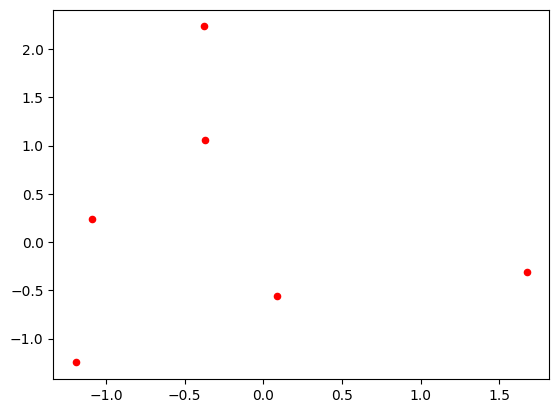

In [32]:
for f in km_model.cluster_centers_:
    plt.scatter(f[0], f[-1], c='red', s=20)
plt.show()

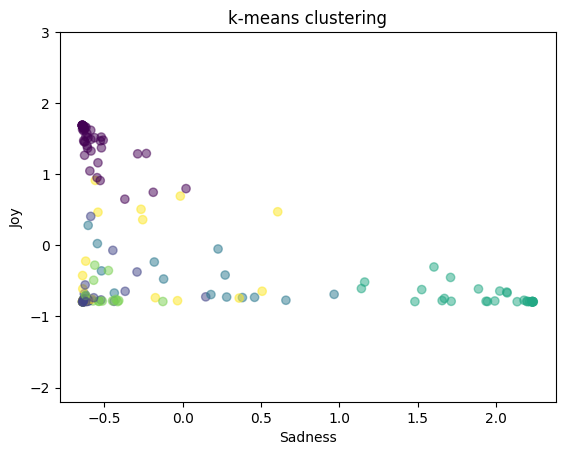

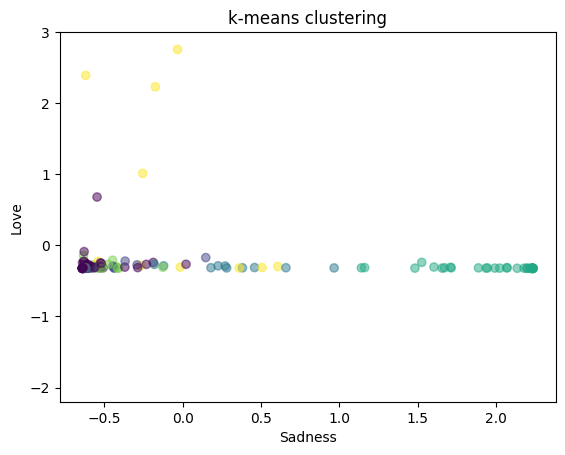

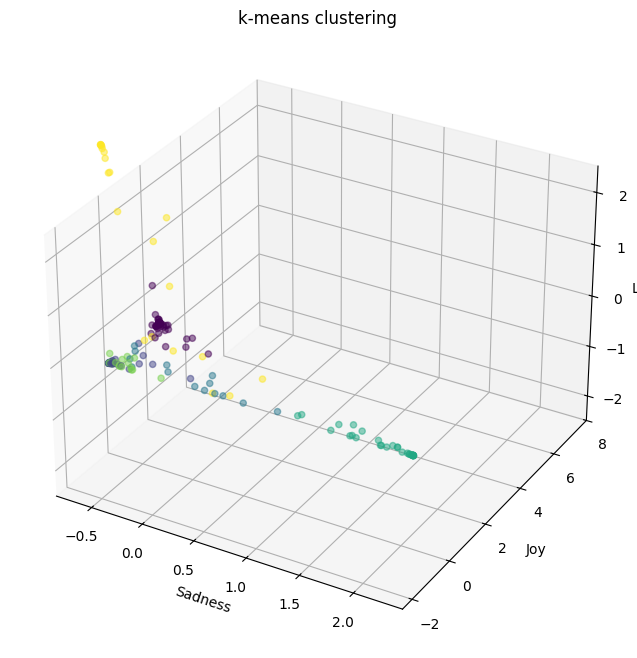

In [33]:
# For plotting
xl, yl, zl = "Sadness", "Joy", "Love"
x = poems_scaled[xl]
y = poems_scaled[yl]
z = poems_scaled[zl]

clusters = km_predicted["clusters"]

# 2D
plt.scatter(x, y, c=clusters, marker='o', linestyle='', alpha=0.5)
plt.title("k-means clustering")
plt.xlabel(xl)
plt.ylabel(yl)
plt.ylim([-2.2, 3])
plt.show()

plt.scatter(x, z, c=clusters, marker='o', linestyle='', alpha=0.5)
plt.title("k-means clustering")
plt.xlabel(xl)
plt.ylabel(zl)
plt.ylim([-2.2, 3])
plt.show()

# 3D
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

ax.scatter(x, y, z, c=clusters, marker='o', linestyle='', alpha=0.5)

ax.set_title("k-means clustering")
ax.set_xlabel(xl)
ax.set_ylabel(yl)
ax.set_zlabel(zl)
ax.set_ylim(-2.5, 8)
ax.set_zlim(-2.5, 2.5)

plt.show()

In [55]:
poems_df["Sentiment Cluster"] = km_predicted["clusters"]
poems_df.head()

,Title,Lines,Words,Word Length,Text,Sadness,Joy,Love,Anger,Fear,Surprise,Sentiment Cluster
0,Introduction,"[Introduction, Cycles can be stupid. You know ...","[Introduction, Cycles, can, be, stupid., You, ...",550,Introduction\nCycles can be stupid. You know w...,0.004606,0.046193,0.001605,0.034378,0.912085,0.001132,1
1,Whenever it’s convenient!,[Screaming\nI want you to see me\nPlease could...,"[Screaming, I, want, you, to, see, me, Please,...",27,Screaming\nI want you to see me\nPlease could ...,0.023822,0.004873,0.011758,0.825398,0.132715,0.001433,4
2,Larger than Life,"[Biding my time,\nI am in no rush.\nPaintbrush...","[Biding, my, time,, I, am, in, no, rush., Pain...",180,"Biding my time,\nI am in no rush.\nPaintbrush ...",0.010388,0.953059,0.002446,0.029157,0.004028,0.000921,0
3,Google Keep,[poems that sit in notes on my phone\nlittered...,"[poems, that, sit, in, notes, on, my, phone, l...",72,poems that sit in notes on my phone\nlittered ...,0.381563,0.025545,0.002885,0.484708,0.101736,0.003562,2
4,Google Keep 2,[poems that sit in notes on my phone\nscribble...,"[poems, that, sit, in, notes, on, my, phone, s...",92,poems that sit in notes on my phone\nscribbles...,0.000948,0.002342,0.995206,0.000341,0.000619,0.000544,5


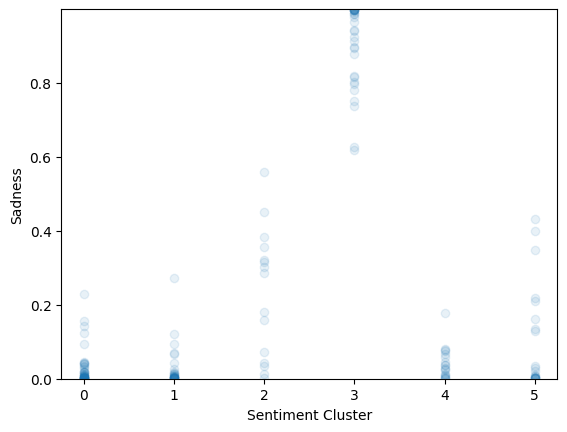

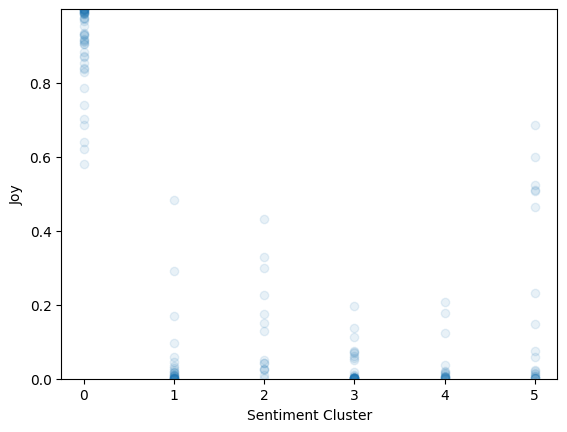

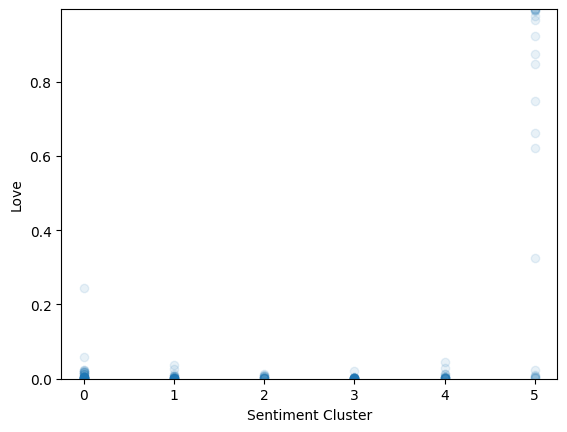

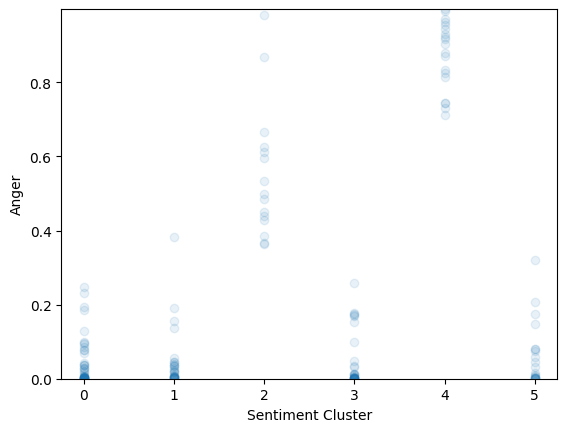

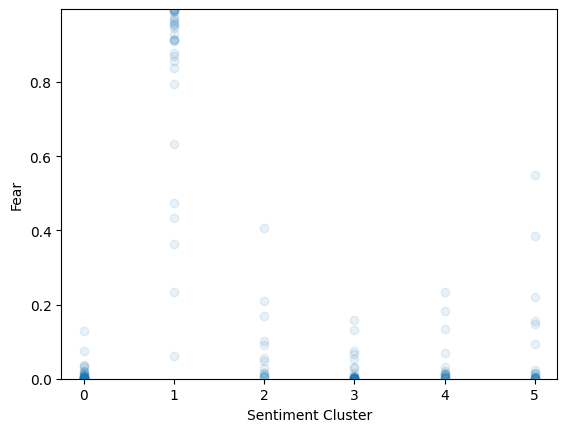

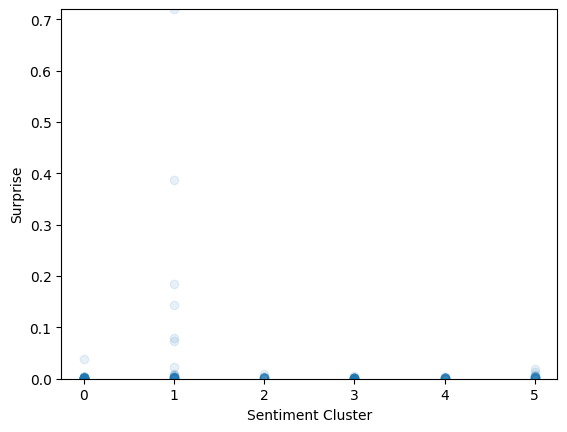

In [61]:
features = ["Sadness", "Joy", "Love", "Anger", "Fear", "Surprise"]
for f in features: 
    plt.scatter(poems_df["Sentiment Cluster"], poems_df[f], alpha=.1)
    plt.xlabel("Sentiment Cluster")
    plt.ylabel(f)
    plt.ylim(0, poems_df[f].max())
    plt.show()


### Analysis

These graphs will help us understand each Sentiment Cluster more.

#### Word Length and Sentiment

Let's plot the sentiment cluster to word length and see if there are any trends!

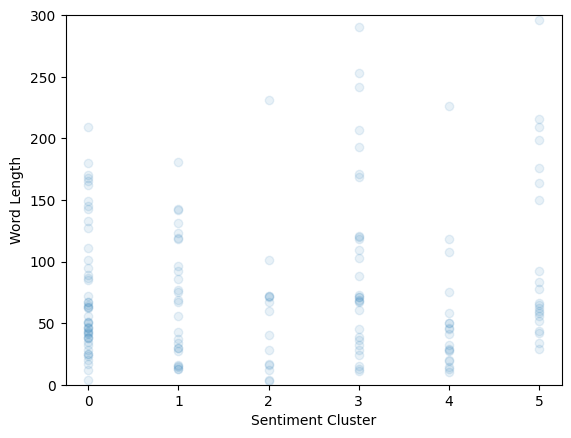

In [59]:
plt.scatter(poems_df["Sentiment Cluster"], poems_df[" Word Length"], alpha=.1)
plt.xlabel("Sentiment Cluster")
plt.ylabel("Word Length")
plt.ylim(0, 300)
plt.show()

### Additional stats about poems